In [2]:
cd ..

/Users/hyunminhong/Kalman-Heston-Filter


In [3]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [4]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=1.5, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


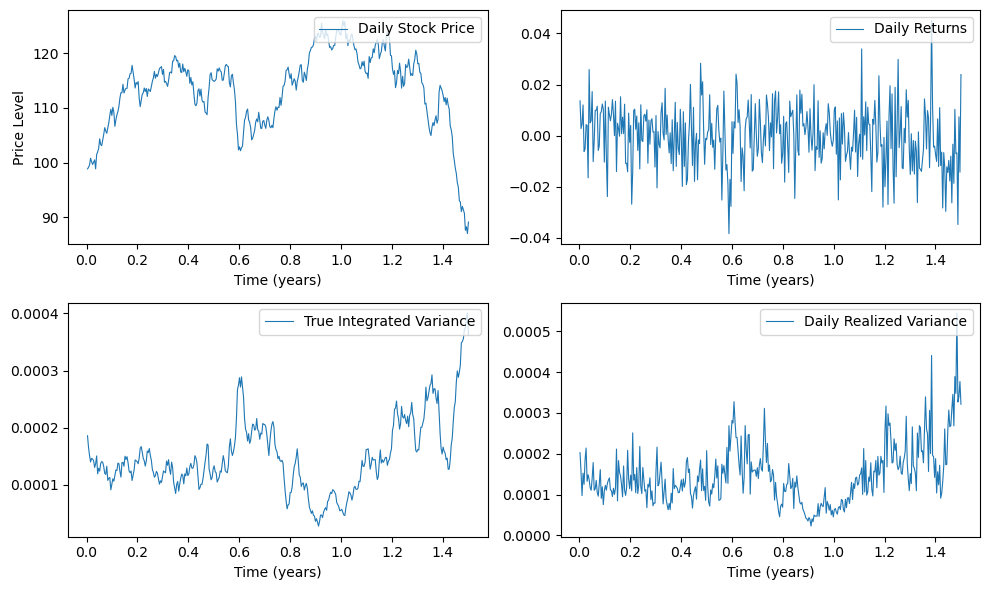

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [6]:
burnin = 252
dt = 1  # Daily

split_index = round(0.6 * 252 * 1.5)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both

In [7]:
# Fit the model using training data
hkf_both = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both.set_data(returns=train_returns, rv=train_RV)
initial_params_both = np.array([0.001, 0.001, 0.001, 0.001, 0.001]) 
# 1e-02, 1e-04, 8e-04, 4e-04, 3.16325904e-06

fit_results_both = hkf_both.fit(initial_params=initial_params_both, burnin=burnin)
params_opt_both = fit_results_both['params']
print("Optimized parameters (BOTH):", params_opt_both)

train_result_both = hkf_both.filter(params_opt_both)
last_V_train = train_result_both['V_filt'][-1]
last_P_train = train_result_both['P_filt'][-1]

hkf_both_test = HestonKalmanFilter(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train, P0=last_P_train)
V_filt_both_test = hkf_both_test.filter(params=params_opt_both, returns=test_returns, rv=test_RV)['V_filt']


QMLE Results for Heston Model:RUNNING THE L-BFGS-B CODE

           * * *


--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
mu: 0.001000
sigma: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [0.001 0.001 0.001 0.001 0.001]
Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0   

### Both - Corr

In [8]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.015, 0.0001, 0.001, 0.001, 0.001, -0.1])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)


QMLE Results for Heston Model:RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

--------------------------------------------------
kappa: 0.015000
theta: 0.000100
xi: 0.001000
mu: 0.001000
sigma: 0.001000
rho: -0.100000
Negative Log-Likelihoo

### Return

In [9]:
# Fit the model using training data
hkf_returns = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.01, P0=0.1)
hkf_returns.set_data(returns=train_returns)
initial_params_returns = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_returns = hkf_returns.fit(initial_params=initial_params_returns, burnin=burnin)
params_opt_returns = fit_results_returns['params']
print("Optimized parameters (RETURNS):", params_opt_returns)

train_result_returns = hkf_returns.filter(params_opt_returns)
last_V_returns = train_result_returns['V_filt'][-1]
last_P_returns = train_result_returns['P_filt'][-1]

hkf_returns_test = HestonKalmanFilter(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns, P0=last_P_returns)
V_filt_returns_test = hkf_returns_test.filter(params=params_opt_returns, returns=test_returns)['V_filt']


QMLE Results for Heston Model:RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
mu: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.001 0.001 0.001 0.001]

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+

### Return - Corr

In [10]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, 0])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)


QMLE Results for Heston Model:RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

--------------------------------------------------
kappa: 0.002000
theta: 0.000100
xi: 0.007000
mu: 0.002000
rho: 0.000000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [0.002  0.0001 0.007  0.002  0.    ]
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1    

### RV

In [11]:
hkf_rv = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=0.01, P0=0.1)
hkf_rv.set_data(rv=train_RV)
initial_params_rv = np.array([0.001, 0.001, 0.001, 0.001])

fit_results_rv = hkf_rv.fit(initial_params=initial_params_rv, burnin=burnin)
params_opt_rv = fit_results_rv['params']
print("Optimized parameters (RV):", params_opt_rv)

train_result_rv = hkf_rv.filter(params_opt_rv)
last_V_rv = train_result_rv['V_filt'][-1]
last_P_rv = train_result_rv['P_filt'][-1]

hkf_rv_test = HestonKalmanFilter(measurement_type=MeasurementType.RV, dt=dt, V0=last_V_rv, P0=last_P_rv)
test_result_rv = hkf_rv_test.filter(params=params_opt_rv, rv=test_RV)


QMLE Results for Heston Model:RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16

--------------------------------------------------
kappa: 0.001000
theta: 0.001000
xi: 0.001000
sigma: 0.001000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RV): [0.001 0.001 0.001 0.001]
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   0.000D+00

### PF

In [12]:
pf_heston_train = PFHeston(train_returns, N=5000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.4),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 889.049413975705
resampling since: 1060.81333963685
resampling since: 812.6467751888108
resampling since: 1007.7117300669755
resampling since: 3496.922769770234
resampling since: 1028.7891816907927
resampling since: 136.2686536546764
resampling since: 2040.7517829849028
resampling since: 3234.7288275380206
resampling since: 1569.441941474467
resampling since: 2817.3040052156794
resampling since: 1570.3513603376819
resampling since: 879.3877140688575
resampling since: 3155.9928990864973
resampling since: 206.1732822211451
resampling since: 435.33711357796875
resampling since: 847.6410160583745
resampling since: 1221.8452318295138
resampling since: 116.80040933943465
resampling since: 2442.0681005818496
resampling since: 2093.1897050592256
resampling since: 3246.9042471935186
resampling since: 3392.309452523619
resampling since: 445.06460127096653
resampling since: 2160.72674247191
resampling since: 2131.4190317763346
resampling since: 2654.8438126576157
resampling sinc

In [13]:
pf_heston_test = PFHeston(test_returns, N=5000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 3129.4080364137208
resampling since: 2214.043891309569
resampling since: 3402.661408109579
resampling since: 2458.2755293746627
resampling since: 403.98572763853434
resampling since: 3198.5850363483555
resampling since: 2073.8544979892586
resampling since: 2653.6851108007995
resampling since: 3308.7646244202574
resampling since: 2748.6089572841033
resampling since: 2498.8590620375785
resampling since: 3102.051609121464
resampling since: 592.7198782643754
resampling since: 3393.495038671675
resampling since: 3291.425026684921
resampling since: 2226.482902376973
resampling since: 3486.8046192995835
resampling since: 3145.2022734235
resampling since: 3301.09645041411
resampling since: 2000.86894211119
resampling since: 2681.4418696399125
resampling since: 1587.3505182741815
resampling since: 2367.0909803575737
resampling since: 3257.8337939820344
resampling since: 3025.643428374631
resampling since: 2483.372255574369
resampling since: 2855.8597223479733
resampling since:

In [14]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

## Plot

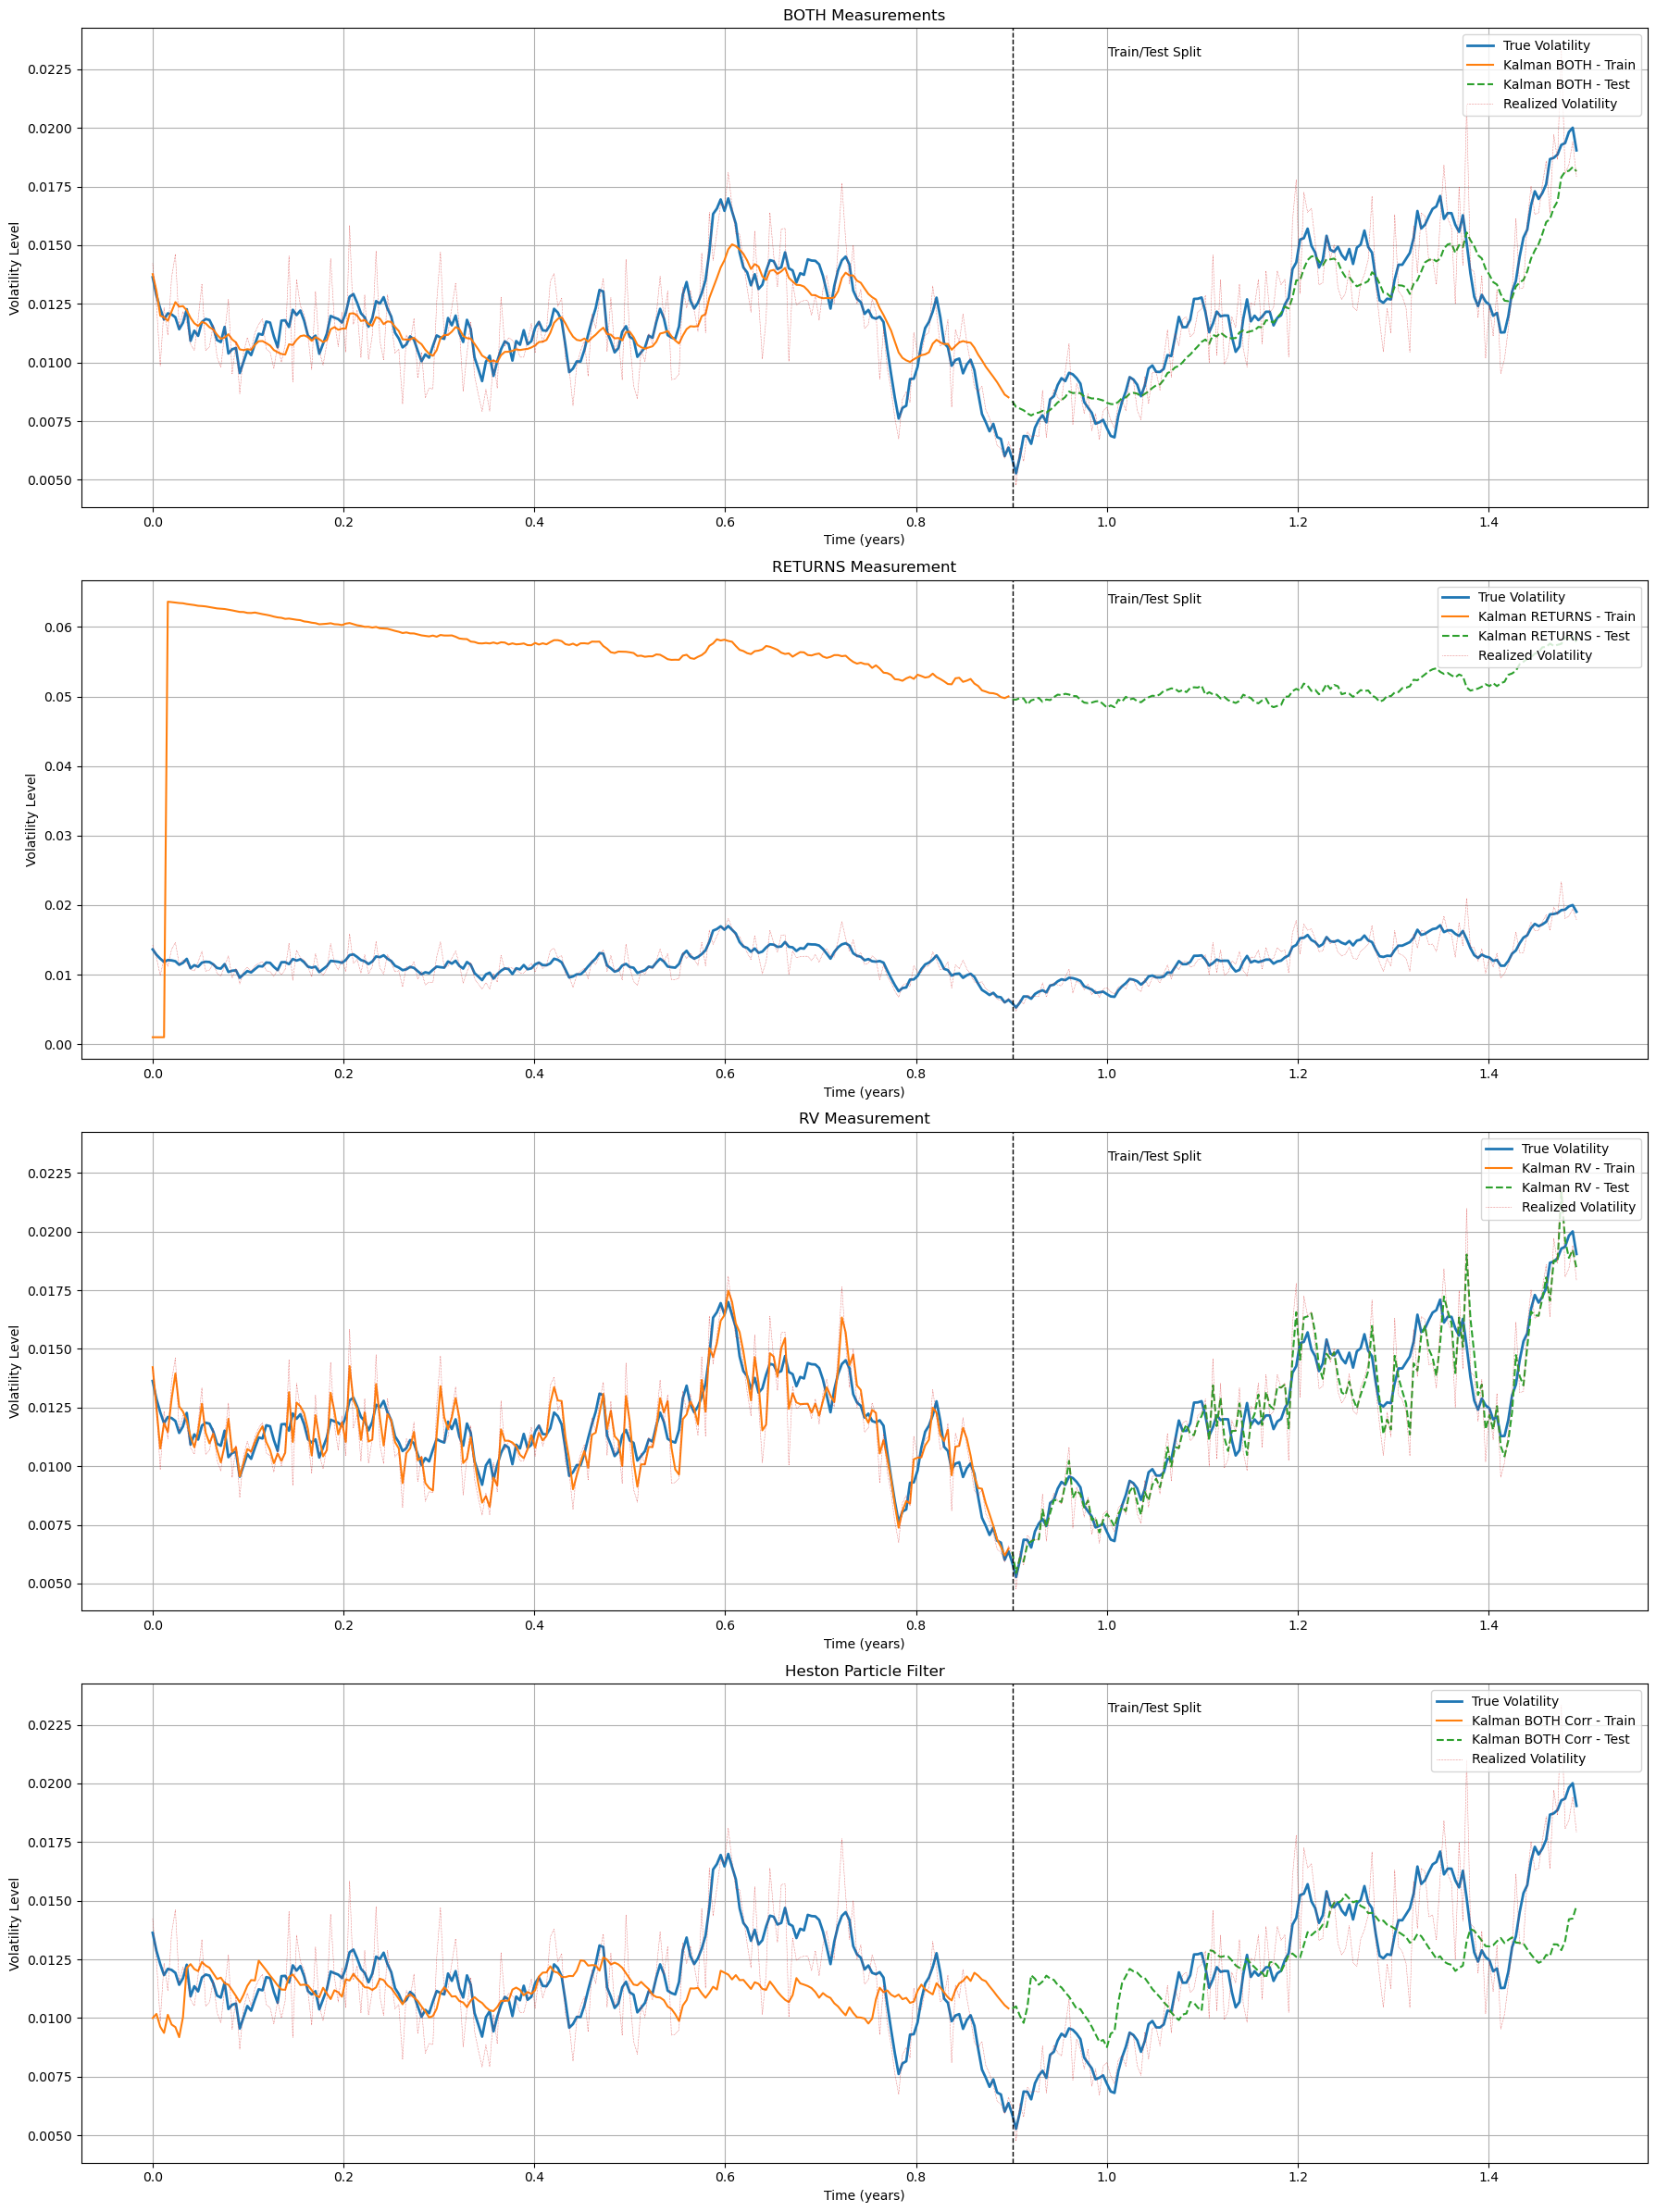

In [15]:
v_item = 'V_filt'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "RV Measurement", "Heston Particle Filter"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman RV", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], train_result_rv[v_item], V_pf_train_daily]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], test_result_rv[v_item], V_pf_test_daily]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0, 
    save_path=r"./output/shortPeriod.png"
)

In [16]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['both_corr', 'returns_corr', 'rv', 'pf']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
mape_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, test_all):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    mape_scores[name]  = mean_absolute_percentage_error(true_volatilities, pred_vol) * 100
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results including QLIKE:")
for name in model_names:
    print(f"{name:12s} MAE: {mae_scores[name]:.6f}, "
          f"RMSE: {rmse_scores[name]:.6f}, "
          f"MAPE: {mape_scores[name]:.3f}%, "
          f"QLIKE: {qlike_scores[name]:.6f}")


Results including QLIKE:
both_corr    MAE: 0.001050, RMSE: 0.001254, MAPE: 8.742%, QLIKE: 0.022455
returns_corr MAE: 0.038767, RMSE: 0.038824, MAPE: 341.921%, QLIKE: 1.961874
rv           MAE: 0.000834, RMSE: 0.001089, MAPE: 6.523%, QLIKE: 0.013829
pf           MAE: 0.002002, RMSE: 0.002570, MAPE: 17.744%, QLIKE: 0.091518


In [17]:
import pandas as pd
data = {}

data['both_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    params_opt_both_corr
))

data['returns_corr'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    params_opt_returns_corr
))
data['returns_corr']['sigma'] = np.nan

data['rv'] = dict(zip(
    ['kappa', 'theta', 'xi', 'sigma'],
    params_opt_rv
))
data['rv']['mu']  = np.nan
data['rv']['rho'] = np.nan

pf_vals = estimated_param[:, -1]
data['pf'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,both_corr,returns_corr,rv,pf
kappa,0.0150,0.0020,0.001,2.486710
theta,0.0001,0.0001,0.001,0.025384
xi,0.0010,0.0070,0.001,0.220229
mu,0.0010,0.0020,NaN,-0.027766
sigma,0.0010,NaN,0.001,NaN
rho,-0.1000,0.0000,NaN,-0.384133


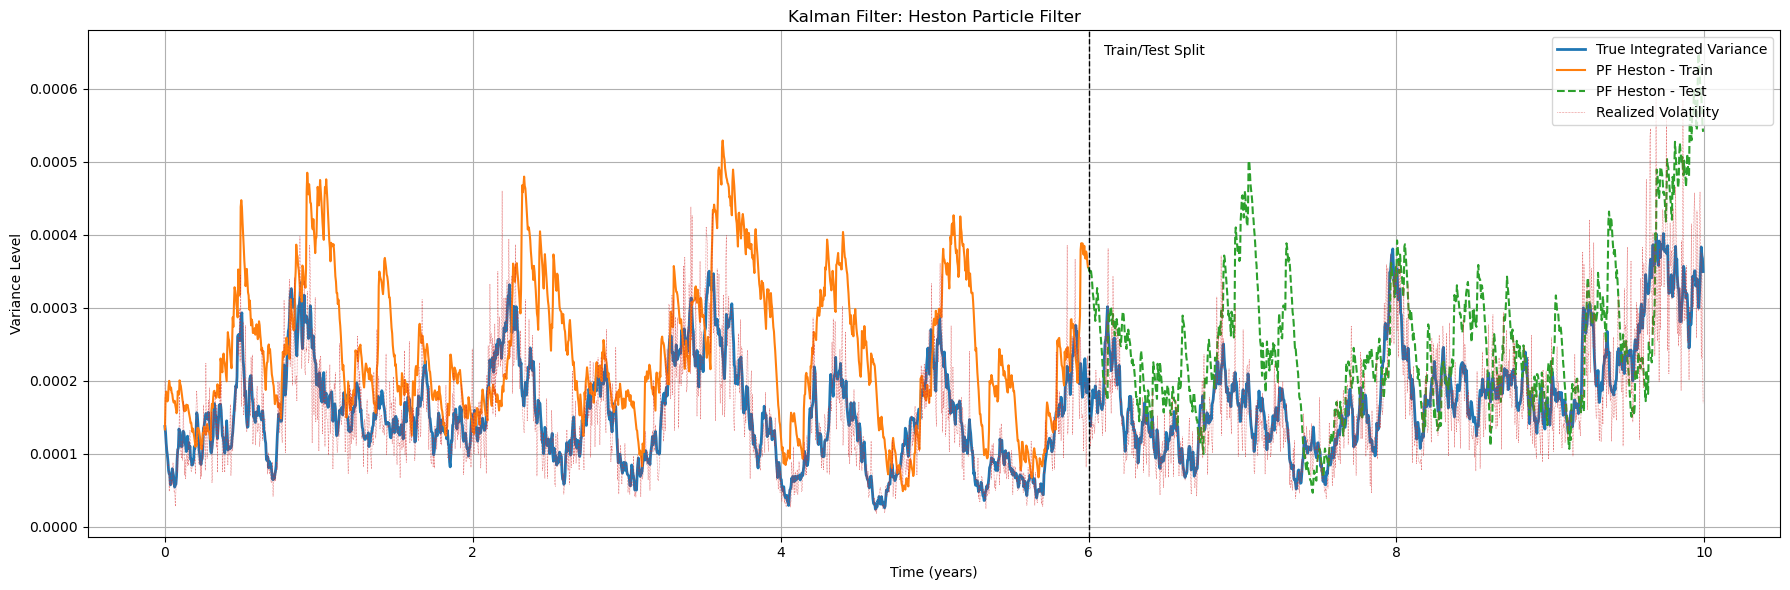

In-Sample RMSE (Heston Particle Filter): 0.000122
Out-of-Sample RMSE (Heston Particle Filter): 0.000110


(0.00012217167608488048, 0.00011009081122822449)

In [27]:
Utility.plot_filter_result(
    plot_index=5,
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=0
)